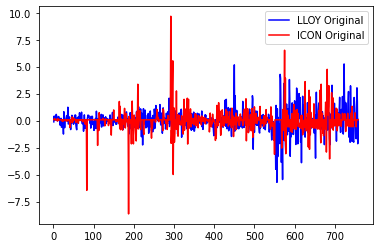

In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv(r"LLOY.L.csv")
df2 = pd.read_csv(r"ICON.L.csv")
df3 = pd.read_csv(r"PREM.L.csv")
df4 = pd.read_csv(r"BOIL.L.csv")

#calculating log return of close values
df['log return'] = np.log(df['Close']).diff()
df2['log return'] = np.log(df2['Close']).diff()
df3['log return'] = np.log(df3['Close']).diff()
df4['log return'] = np.log(df4['Close']).diff()

#normalzing the dataframe
x = df.copy()
del x["Date"]
df_normalized = (x-x.mean())/x.std()
x = df2.copy()
del x["Date"]
df_normalized2 = (x-x.mean())/x.std()
x = df3.copy()
del x["Date"]
df_normalized3 = (x-x.mean())/x.std()
x = df4.copy()
del x["Date"]
df_normalized4 = (x-x.mean())/x.std()

df_normalized["log return"].plot(color = "blue", label = "LLOY Original")
plt.legend()
df_normalized2["log return"].plot(color = "red", label = "ICON Original")
plt.legend()

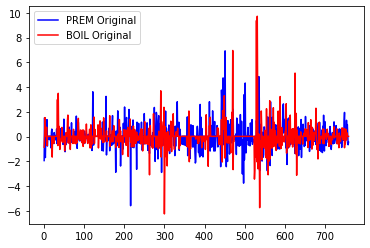

In [2]:
df_normalized3["log return"].plot(color = "blue", label = "PREM Original")
plt.legend()
df_normalized4["log return"].plot(color = "red", label = "BOIL Original")
plt.legend()

In [3]:
#segmenting
#dropping first row
df_normalized = df_normalized.iloc[1:]
df_normalized2 = df_normalized2.iloc[1:]
df_normalized3 = df_normalized3.iloc[1:]
df_normalized4 = df_normalized4.iloc[1:]
tol = 0.05 # tolerance at 1%, 5% and 10%
tolerance = tol*df_normalized["log return"].var()
#tolerance = tol*df["log return"].var()

#convert date to numerical format
import datetime
df['conv_date'] = pd.to_datetime(df['Date'], format="%Y-%M-%d")
df['conv_date'] = df['conv_date'].map(datetime.datetime.toordinal)
df_normalized["Date"] = df['conv_date']
#print(df_normalized)

In [4]:
def segmentation(logs): 
    #SEGMENTING
    x1 = logs
    y1 = list(df_normalized["Date"])
    i = 0
    split = []

    #splitting the values into k segments
    from itertools import islice
    from itertools import accumulate
    while i < len(logs):
        if (len(logs)%2!=0 and i == len(logs)-3):
            split.append(3)
            break
        split.append(2)
        i = i + 2
    Output = [logs[x - y: x] for x, y in zip(accumulate(split), split)]
    Time = [y1[x - y: x] for x, y in zip(accumulate(split), split)]
    err = []
    def linreg (x,y):
        sqx = [number ** 2 for number in x]
        sqy = [number ** 2 for number in y]
        xy = [numb*number for numb,number in zip(x,y)]
        a = (sum(y)*sum(sqx)-sum(x)*sum(xy))/(len(x)*sum(sqx)-sum(x)**2)
        b = (len(x)*sum(xy)-sum(x)*sum(y))/(len(x)*sum(sqx)-sum(x)**2)
        y_ = []
        for i in range(len(x)):
            y_.append(a + b*x[i])
        Er = 0
        for i in range(len(y)):
            Er = Er + (y[i]-y_[i])**2
        return Er

    for i in range(len(Output)):
        if (len(Output[i])%2!=0):
            err.append(linreg(Time[i],Output[i]))
        err.append(0)
    totalErrOld = sum(err)
    totalErr = 10000000000000000000
    n = len(df)

    #some variable for the loop
    cons = 1
    while(cons != 400): #loop will break due to the tolerance
        i = 0
        while i < len(Output) - 1:
            outp = []
            outp.append(Output[i])
            outp.append(Output[i+1])
            outp = [j for z in outp for j in z]
            tim = []
            tim.append(Time[i])
            tim.append(Time[i+1])
            tim = [j for z in tim for j in z]
            Err1 = linreg(tim, outp)
            if totalErr > (totalErrOld - err[i] - err[i+1] + Err1):
                totalErr = totalErrOld - err[i] - err[i+1] + Err1
                index = []
                index.append(i)
                index.append(i+1+1)
            if totalErr/n >= tolerance:
#                print("loop broken")
                break
            if i == (len(Output) - 2):
                s = []
                t = []
                for u in range(index[0],index[1]):
                    s = s + Output[u]
                    t = t + Time[u]
                Output[index[0]:index[1]] = [s]
                Time[index[0]:index[1]] = [t]
                err[index[0]] = totalErr - totalErrOld + err[index[0]] + err[index[1]-1]
                del err[index[1]-1]
                totalErrOld = sum(err)
            i = i + 1
        if totalErr/n >= tolerance:
#            print("loop broken")
            break
        cons = cons + 1
        totalErr = 100000000000

    result=[]
    print(len(Output))
    for i in range(len(Output)):
        result.append(Output[i][0]) #first element of segment i
        result.append(Output[i][-1]) #last element of segment i
    #print(len(result))
    result = pd.DataFrame(result)
    #print(result)
    #result[0].plot(color = "red", label = "LLOY Segmented at 1% Tolerance")
    #plt.legend(loc="upper left", fontsize = 10)
    return result

202
404
            0
0   -0.115265
1   -0.607382
2   -0.604075
3   -0.379108
4   -1.245818
..        ...
399  1.484208
400  3.037660
401  1.769191
402 -2.142080
403  0.101957

[404 rows x 1 columns]


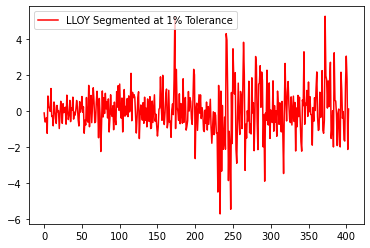

In [5]:
logs = list(df_normalized["log return"])
c = segmentation(logs)
print(len(c))
print(c)
c[0].plot(color = "red", label = "LLOY Segmented at 1% Tolerance")
plt.legend(loc="upper left", fontsize = 10)

190
380
            0
0    0.090214
1    0.075837
2   -6.463628
3   -0.117741
4    0.075837
..        ...
375  0.075837
376 -0.526652
377  0.726576
378  0.075837
379  0.075837

[380 rows x 1 columns]


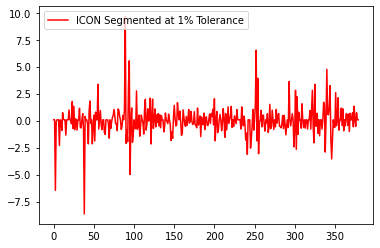

In [6]:
logs = list(df_normalized2["log return"])
c = segmentation(logs)
print(len(c))
print(c)
c[0].plot(color = "red", label = "ICON Segmented at 1% Tolerance")
plt.legend(loc="upper left", fontsize = 10)

227
454
            0
0   -1.937061
1    1.529611
2   -1.158891
3   -1.693355
4    0.027786
..        ...
449  0.027786
450  1.317608
451  0.027786
452  0.971644
453 -0.453049

[454 rows x 1 columns]


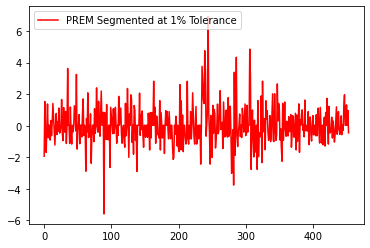

In [7]:
logs = list(df_normalized3["log return"])
c = segmentation(logs)
print(len(c))
print(c)
c[0].plot(color = "red", label = "PREM Segmented at 1% Tolerance")
plt.legend(loc="upper left", fontsize = 10)

164
328
            0
0   -0.852149
1    0.019227
2    1.536923
3    0.019227
4    0.761381
..        ...
323  0.289906
324  0.665548
325 -0.570031
326  0.608485
327  0.019227

[328 rows x 1 columns]


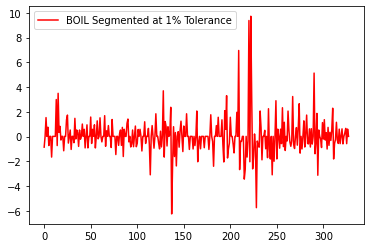

In [8]:
logs = list(df_normalized4["log return"])
c = segmentation(logs)
print(len(c))
print(c)
c[0].plot(color = "red", label = "BOIL Segmented at 1% Tolerance")
plt.legend(loc="upper left", fontsize = 10)